# Implementation of a linear interpolation for multivariate time series using numba

In [1]:
import numpy as np, numba as nb, matplotlib.pyplot as plt

## Implementations

In [2]:
# for loops ===============================================================
def interp_np_matrix(new_x:np.array, x:np.array, y: np.matrix) -> np.matrix:
    interpolated = np.empty((len(new_x),y.shape[1]),dtype=np.float64)
    for y_col in range(y.shape[1]):
        interpolated[:,y_col] = np.core.multiarray.interp(new_x, x, y[:,y_col])
    return interpolated

@nb.guvectorize([(nb.float64[:], nb.float64[:], nb.float64[:,:], nb.float64[:,:])], '(p),(n),(n,m)->(p,m)')
def vinterp(new_x, x, y, res):
    for y_col in range(y.shape[1]):
        res[:,y_col] = np.interp(new_x, x, y[:,y_col])

def interp_np_multi(new_x, x, y):
    y_new = y.copy()
    np.apply_along_axis(lambda t: np.interp(new_x, x, t), 0, y_new)
    return y_new

# hacky numerical broadcasting/matrix multiplications =========================================
def multiInterp2(new_x, xp, fp):
    j = np.searchsorted(xp, new_x) - 1
    d = (new_x - xp[j]) / (xp[j + 1] - xp[j])
    D = np.tile(d, (fp.shape[1], 1))
    return ((1 - D) * fp[j, :].T + fp[j+1, :].T * D).T

@nb.jit(nb.float64[:,:](nb.float64[:], nb.float64[:], nb.float64[:,:]))
def multiInterp2_nb(new_x, xp, fp):
    # calculates indices where a value 'h' of new_t must be placed in t such that t
    # is ordered correctly, giving the upper bound. subtract 1 to get the lower bound.
    # e.g. t = [1, 2], new_t = [1, 1.3, 1.6, 2], then insertion points = [0, 1, 1, 1]
    # because for 1, upper bound is 1 => index 0; for 1.3, upper bound is 2 => index 1, etc...
    j = np.searchsorted(xp, new_x) - 1
    
    # calculates the fraction of the interval range of a new value to reach that new value from the lower bound.
    d = (new_x - xp[j]) / (xp[j + 1] - xp[j])

    # repeat and reshape for matrix multiplication
    D = np.repeat(d, fp.shape[1])
    D = np.reshape(D, (d.shape[0], -1))

    # calculates new interpolated values of other columns using fractions calculated in target column.
    return fp[j, :] + D * (fp[j+1, :] - fp[j, :])

# via vectorize decorator ===============================================
@np.vectorize(signature='(a),(b),(n)->(a)') # signature param creates gufunc
def _interp_np_vec_all_np(new_x, x, fp):
    return np.interp(new_x, x, fp)

def interp_np_vec_all_np(new_x, x, fp):
    return _interp_np_vec_all_np(new_x[None, ...], x[None, ...], fp.T).T

@nb.guvectorize([(nb.float64[:], nb.float64[:], nb.float64[:], nb.float64[:])], '(a),(b),(n)->(a)')
def _interp_np_vec_all_nb(new_x, x, fp, res):
    res[:] = np.interp(new_x, x, fp) #[:] important, you cant assign a new array but need to fill

def interp_np_vec_all_nb(new_x, x, fp):
    return _interp_np_vec_all_nb(new_x[None, ...], x[None, ...], fp.T).T

# with currying =========================================================
def create_interp_func_np(new_x, x):
    @np.vectorize(signature=('(n)->(m)'))
    def interp_np_multi2(y):
        return np.interp(new_x, x, y)
    return interp_np_multi2


def create_interp_func_np2(new_x, x):
    def wrapper(fp):
        @np.vectorize(signature=('(n)->(m)'))
        def interp_np_multi2(y):
            return np.interp(new_x, x, y)
        return interp_np_multi2(fp.T).T
    return wrapper

## Performance Tests

In [3]:
columns = 10000
timesteps = 10000

t = np.linspace(0, 1000, timesteps)
t2 = np.linspace(0, 1000, timesteps * 2)
Y = np.array([np.random.rand(columns)]*timesteps)
Y2 = np.array([np.random.rand(columns)]*(timesteps*2))

print(f"{t.shape=}, {Y.shape=}")
print(f"{t2.shape=}, {Y2.shape=}")

t.shape=(10000,), Y.shape=(10000, 10000)
t2.shape=(20000,), Y2.shape=(20000, 10000)


In [5]:
a = create_interp_func_np(t2, t)
b = create_interp_func_np2(t2, t)
# execute once for compilation
interp_np_vec_all_nb(t2, t, Y)
multiInterp2_nb(t2, t, Y)
a(Y.T).T
b(Y)

# Some of the timing have been varying greatly. it might be due to jupyter notebook server,
# caching or other side effects. Rebooting helps sometimes.

print("="*10 + "For-loops/numpy functions" + "="*10)
print(f"{'interp_np_matrix':32}: ", end="")
%timeit interp_np_matrix(t2, t, Y)
print(f"{'vinterp':32}: ", end="")
%timeit vinterp(t2, t, Y)
print(f"{'interp_np_multi':32}: ", end="")
%timeit interp_np_multi(t2, t, Y)
print("="*10 + "Numerical Broadcasting" + "="*10)
print(f"{'multiInterp2':32}: ", end="")
%timeit multiInterp2(t2, t, Y)
print(f"{'multiInterp2_nb':32}: ", end="")
%timeit multiInterp2_nb(t2, t, Y) 
print("="*10 + "Vectorization" + "="*10)
print(f"{'interp_np_vec_all_np':32}: ", end="")
%timeit interp_np_vec_all_np(t2, t, Y)
print(f"{'interp_np_vec_all_nb':32}: ", end="")
%timeit interp_np_vec_all_nb(t2, t, Y)
print("="*10 + "Currying" + "="*10)
print(f"{'create_interp_func_np':32}: ", end="")
%timeit a(Y.T).T
print(f"{'create_interp_func_np2':32}: ", end="")
%timeit b(Y)

==========For-loops/numpy functions==========
interp_np_matrix                : 2.85 s ± 59.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
vinterp                         : 3.93 s ± 44.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
interp_np_multi                 : 1.92 s ± 31.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
==========Numerical Broadcasting==========
multiInterp2                    : 6.71 s ± 114 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
multiInterp2_nb                 : 1.69 s ± 12.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
==========Vectorization==========
interp_np_vec_all_np            : 1.87 s ± 16.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
interp_np_vec_all_nb            : 2.52 s ± 57.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
==========Currying==========
create_interp_func_np           : 1.76 s ± 36.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
create_interp_func_np2          :

In [7]:
multiInterp2_nb(t, t2, Y2)

print("="*10 + "Numerical Broadcasting" + "="*10)
#print(f"{'multiInterp2':32}: ", end="")
#%timeit multiInterp2(t, t2, Y)
print(f"{'multiInterp2_nb':32}: ", end="")
%timeit multiInterp2_nb(t, t2, Y2) 

==========Numerical Broadcasting==========
multiInterp2_nb                 : 738 ms ± 13.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Visualization

In [72]:
t = np.linspace(0, 10, 25)
t2 = np.linspace(0, 10, 50)
Y = np.array([list(a) for a in zip(np.sin(t), np.cos(t))])
Y_t2 = np.array([list(a) for a in zip(np.sin(t2), np.cos(t2))])
Y2 = multiInterp2_nb(t2, t, Y)
Y3 = multiInterp2_nb(t, t2, Y_t2)

C:\Users\slohr\AppData\Local\Temp\ipykernel_14476\4178550385.py:10: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


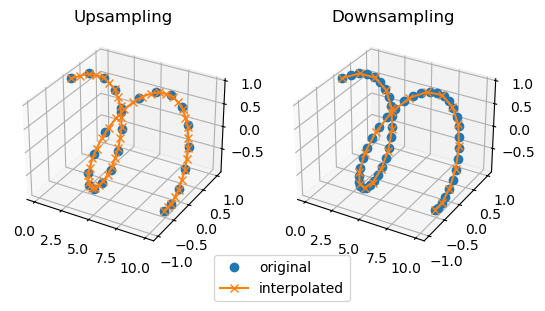

In [73]:
fig, (ax1, ax2) = plt.subplots(ncols=2, subplot_kw={'projection': '3d'})
a1, = ax1.plot(t, Y[:,0], Y[:,1], 'o', label='original')
a2, = ax1.plot(t2, Y2[:,0], Y2[:,1], '-x', label='interpolated')
ax1.set_title("Upsampling")
ax2.plot(t2, Y_t2[:,0], Y_t2[:,1], 'o', label='original')
ax2.plot(t, Y3[:,0], Y3[:,1], '-x', label='interpolated')
ax2.set_title("Downsampling")

fig.legend(handles=[a1, a2], loc='lower center', bbox_to_anchor=(0.55, 0.15))
fig.show()

## Summary

Function `multiInterp2_nb` has the best performance in the tests.  
It is using matrix operations to perform linear interpolation based on a target column (usually time), which works properly for downsampling and upsampling with the same start/end points. The speedup mainly results from the compilation into C-code via numba. Since the implementation uses matrix operations, this could in principle parallelized. The figure above shows the correct interpolation of a multivariate time series.  
As seen in the figure below, extrapolation is not intended and results in nonsense data if remaining points that exceed the original maximum. An assertion should be added that catches this edge case.

C:\Users\slohr\AppData\Local\Temp\ipykernel_14476\2972587926.py:16: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


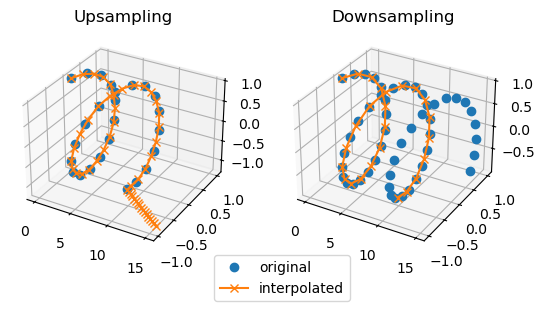

In [74]:
t = np.linspace(0, 10, 25)
t2 = np.linspace(0, 15, 50)
Y = np.array([list(a) for a in zip(np.sin(t), np.cos(t))])
Y_t2 = np.array([list(a) for a in zip(np.sin(t2), np.cos(t2))])
Y2 = multiInterp2_nb(t2, t, Y)
Y3 = multiInterp2_nb(t, t2, Y_t2)
fig, (ax1, ax2) = plt.subplots(ncols=2, subplot_kw={'projection': '3d'})
a1, = ax1.plot(t, Y[:,0], Y[:,1], 'o', label='original')
a2, = ax1.plot(t2, Y2[:,0], Y2[:,1], '-x', label='interpolated')
ax1.set_title("Upsampling")
ax2.plot(t2, Y_t2[:,0], Y_t2[:,1], 'o', label='original')
ax2.plot(t, Y3[:,0], Y3[:,1], '-x', label='interpolated')
ax2.set_title("Downsampling")

fig.legend(handles=[a1, a2], loc='lower center', bbox_to_anchor=(0.55, 0.15))
fig.show()